In [1]:
import json
with open('.\\Presets\\parameters.json', 'r') as paras_json:
    # Load the content of the JSON file
    data = json.load(paras_json)
    
    # Extract the parameters
    array_paras = data['RGB_array_parameters']
    lt_paras = data['LT_parameters']

# Now you can use array_paras and lt_paras as needed
print(array_paras)
print(lt_paras)


{'Scale': {'value': '0.5', 'type': 'value', 'regex': "r'^[-]*\\d+[.]\\d+$'", 'parser': 'float(val)', 'options': None}, 'Pixel Number': {'value': '5x5', 'type': 'value', 'regex': "r'^\\d+x\\d+$'", 'parser': "(int(val.split('x')[0]), int(val.split('x')[1]))", 'options': None}, 'Pixel Pitch': {'value': '60x60', 'type': 'value', 'regex': '^\\\\d+\\\\.\\\\d+x\\\\d+\\\\.\\\\d+$', 'parser': "(float(val.split('x')[0]), float(val.split('x')[1]))", 'options': None}, 'Pixel Size': {'value': '50x50', 'type': 'value', 'regex': '^\\\\d+\\\\.\\\\d+x\\\\d+\\\\.\\\\d+$', 'parser': "(float(val.split('x')[0]), float(val.split('x')[1]))", 'options': None}, 'Row Offset': {'value': '0', 'type': 'value', 'regex': '^[-]*\\d+[.]\\d+$', 'parser': 'float(val)', 'options': None}, 'Sub-pixel Pitch': {'value': '30x30', 'type': 'value', 'regex': '^\\\\d+\\\\.\\\\d+x\\\\d+\\\\.\\\\d+$', 'parser': "(float(val.split('x')[0]), float(val.split('x')[1]))", 'options': None}, 'Sub-pixel Size': {'value': '20x20', 'type': 'va

In [2]:
a = (1, 2)
b, c = a
print(b, c)

1 2


In [3]:
def parse_sub_pixel(sub_px_order):
    sub_px_list = sub_px_order.split('|')
    output = []
    # if len(sub_px_list) == 1:
    #     output.append(list(sub_px_order))
    #     return 
    for r in sub_px_list:
        output.append(list(r))
    return output


sub_px_order = ['RG|B', 'RG|GB', 'R|G|B', 'RGB']

for o in sub_px_order:
    print(parse_sub_pixel(o))

[['R', 'G'], ['B']]
[['R', 'G'], ['G', 'B']]
[['R'], ['G'], ['B']]
[['R', 'G', 'B']]


In [4]:
a = parse_sub_pixel('R|G|B')
b = parse_sub_pixel('RGB')
print(len(a[0]), len(b[0]))

1 3


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

def gen_pixel(canvas, px_pos, sub_px_pad, sub_px_size, sub_px_pitch, sub_px_order_str):    
    sub_px_order = parse_sub_pixel(sub_px_order_str)
    sub_px_size_dict = {'R':None, 'G':None, 'B':None, 'W':None}
    sub_px_color = {'R':(0, 0, 255), 'G':(0, 255, 0), 'B':(255, 0, 0), 'W':(255, 255, 255)}
    if not isinstance(sub_px_size, list):       
        sub_px_size_dict = {k:sub_px_size for k in sub_px_size_dict.keys()}
    else:
        sub_px_size_dict['R'] = sub_px_size[0]
        sub_px_size_dict['G'] = sub_px_size[1]
        sub_px_size_dict['B'] = sub_px_size[2]
        sub_px_size_dict['W'] = sub_px_size[3]

    for j, r in enumerate(sub_px_order):
        for i, c in enumerate(r):
            top_left_x, top_left_y = (px_pos[0] + sub_px_pad[0] + i * sub_px_pitch[0]), (px_pos[1] + sub_px_pad[1] + j * sub_px_pitch[1])
            bottom_right_x, bottom_right_y = (top_left_x + sub_px_size_dict[c][0]), (top_left_y + sub_px_size_dict[c][1])
            cv2.rectangle(canvas, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), sub_px_color[c], -1)      
    return canvas


def gen_array(px_scale, px_num, px_pitch, px_size, row_offset, sub_px_size, sub_px_pitch, sub_px_pad, sub_px_order):
    px_pitch = (np.array(px_pitch) * px_scale).astype('uint8')
    px_size = (np.array(px_size) * px_scale).astype('uint8')
    px_num = np.array(px_num)
    array_size = px_pitch * (px_num - 1) + px_size
    array_im = np.zeros([array_size[1], array_size[0], 3], dtype='uint8')
    sub_px_pitch = (np.array(sub_px_pitch) * px_scale).astype('uint8')
    # sub_px_size = ((np.array(s).astype('uint8') * px_scale) for s in sub_px_size)
    if isinstance(sub_px_size, list):
        sub_px_size = [(np.array(s).astype('uint8') * px_scale) for s in sub_px_size]
    else:
        sub_px_size = (int(sub_px_size[0] * px_scale), int(sub_px_size[1] * px_scale))
    sub_px_pad = (np.array(sub_px_pad) * px_scale).astype('uint8')
    # px_pos = np.array([0, 0])
    px_orig_pos = np.array([0, 0])
    for j in range(px_num[1]):
        # px_pos = np.array([0, 0]) + np.array([px_pos[0] + row_offset * (j % 2) * px_pitch[0], 0])
        px_orig_pos = px_orig_pos + np.array([row_offset * (j % 2) * px_pitch[0], 0])
        for i in range(px_num[0]):
            px_pos = px_orig_pos + px_pitch * (np.array([i, j]))
            gen_pixel(array_im, px_pos, sub_px_pad, sub_px_size, sub_px_pitch, sub_px_order[j % len(sub_px_order)])
    
    output_msg = f'''Array Size: {(array_size / px_scale)[0]} x {(array_size / px_scale)[1]}
                     Array Dimension: {px_num[0]} x {px_num[1]}
                     Pixel Pitch: {px_pitch[0] / px_scale} x {px_pitch[1] / px_scale}
                  '''
    return array_im, output_msg

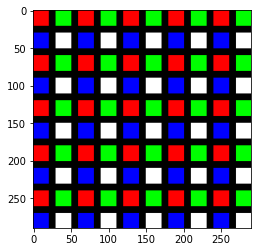

In [6]:
px_num = (5, 5)
px_size = (50, 50)
px_pitch = (60, 60)
row_offset = 0
px_scale = 1
sub_px_pad = (0, 0)
# sub_px_size = (20, 20)
sub_px_size = (20, 20)
sub_px_pitch = (30, 30)
sub_px_order_str = 'RG|BW'
sub_px_order = ['RG|BW']

canvas_im, output_msg = gen_array(px_scale, px_num, px_pitch, px_size, row_offset, sub_px_size, sub_px_pitch, sub_px_pad, sub_px_order)


canvas_im = cv2.cvtColor(canvas_im, cv2.COLOR_BGR2RGB)
plt.imshow(canvas_im)

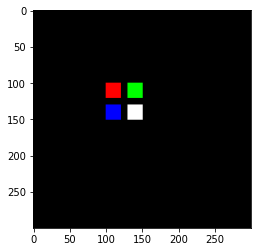

In [7]:
canvas = np.zeros([300, 300, 3], dtype='uint8')

px_pos = (100, 100)
px_scale = 1
sub_px_pad = (0, 0)
# sub_px_size = (20, 20)
sub_px_size = (20, 20)
sub_px_pitch = (30, 30)
sub_px_order_str = ('RG|BW')

canvas_im = gen_pixel(canvas, px_pos, sub_px_pad, sub_px_size, sub_px_pitch, sub_px_order_str)
# cv2.rectangle(canvas_im, px_pos, (), (255, 255, 0), 1)
canvas_im = cv2.cvtColor(canvas_im, cv2.COLOR_BGR2RGB)
plt.imshow(canvas_im)

In [8]:
print(canvas_im.dtype)

uint8


In [9]:
import textwrap
array_size = np.array([100, 100])
px_scale = 1
px_num = (5, 5)
px_size = (50, 50)
px_pitch = (60, 60)
output_msg = f'''Array Size: {(array_size / px_scale)[0]} x {(array_size / px_scale)[1]}
Array Dimension: {px_num[0]} x {px_num[1]}
Pixel Pitch: {px_pitch[0] / px_scale} x {px_pitch[1] / px_scale}
'''
output_msg = textwrap.dedent(output_msg)

print(output_msg)


Array Size: 100.0 x 100.0
Array Dimension: 5 x 5
Pixel Pitch: 60.0 x 60.0



In [10]:
a = np.array([1.0, 1.0])
b = a.astype('uint8')
print(a, b)

[1. 1.] [1 1]


In [11]:
for i, c in enumerate(['R', 'G', 'B']):
    output_fn = f'{c}.txt'
    print(output_fn)

R.txt
G.txt
B.txt


In [12]:
array_im_preview = np.load('.\\array_im_preview.npy')
array_im = np.load('.\\array_im.npy')

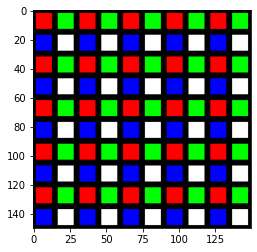

In [13]:
plt.imshow(array_im_preview)


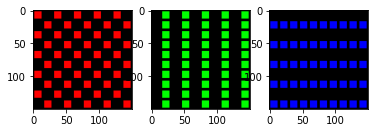

In [14]:
main_array = array_im_preview
array_im_r = np.zeros_like(main_array)
array_im_g = np.zeros_like(main_array)
array_im_b = np.zeros_like(main_array)
array_im_r[:, :, 0] = main_array[:, :, 0]
array_im_g[:, :, 1] = main_array[:, :, 1]
array_im_b[:, :, 2] = main_array[:, :, 2]
fig, ax = plt.subplots(1, 3)
ax[0].imshow(array_im_r) 
ax[1].imshow(array_im_g) 
ax[2].imshow(array_im_b) 
# plt.imshow(array_im_r)
# plt.imshow(array_im_g)
# plt.imshow(array_im_b)

In [23]:
class Custom_Error(Exception):
    def __init__(self, message, code):
        self.message = message
        self.code = code

class LT_Error():
    def __init__(self):    
        self.error_codes = { 0 : " ltStatusSuccess" , 1 : " ltStatusBadInputParameter" , 2 : " ltStatusOutOfMemory" , 10 : " ltStatusWrongVariableType" , 
            11 : " ltStatusVariableNotDefined" , 12 : " ltStatusVariableCantBeSetToGivenValue" , 13 : " ltStatusUndefinedOption" , 20 : " ltStatusInvalidExpression" , 
                30 : " ltStatusDatakeyNotFound" , 32 : " ltStatusInvalidDataAccessString" , 33 : " ltStatusInvalidFunctionString" , 34 : " ltStatusWrongDataType" , 
                    35 : " ltStatusDatakeyNotSelected" , 40 : " ltStatusViewNotFound" , 41 : " ltStatusProblemAccessingViewData" , 50 : " ltStatusInvalidSelectList" , 
                        51 : " ltStatusListNotCreated" , 52 : " ltStatusListIsEmpty" , 53 : " ltStatusEndOfList" , 54 : " ltStatusInvalidListPosition" , 
                            60 : " ltStatusQuickRayPrerequisiteNotEstablished" , 61 : " ltStatusQuickRayMissedSurface" , 70 : " ltStatusCommandNotCompleted"}
    def check_error(self, lt_stat):
        if lt_stat != 0:
            raise Custom_Error(self.error_codes[lt_stat], lt_stat)

In [26]:
lt_error = LT_Error()
lt_error.error_codes[12]

' ltStatusVariableCantBeSetToGivenValue'

In [ ]:
for color in ['R', 'G', 'B']:
apod_file_path_key = f'LENS_MANAGER[1].COMPONENTS[Components].GROUP[group_Freeform_PBS_KF_2D_Complete].GROUP[group_RGB_24um_1.92x1.95].CUBE_SURFACE_SOURCE[CuboidSource_{color}_1].NATIVE_EMITTER[RightSurface].SURFACE_GRID_APODIZER[SurfaceGridApodizer]'
apod_fn = replace_color(a, color)
print(f'Setting up apod file as: {apod_fn}')
lt.DbSet(apod_file_path_key, 'LoadFileName', f"D:\\Garden\\Wayne\\Python\\LT Freeform\\Apod Files\\{apod_fn}.txt")
lt.DbSet(apod_file_path_key, 'LoadFileName', f"D:\\Garden\\Wayne\\Python\\LT Freeform\\Apod Files\\{apod_fn}.txt")
lt.DbSet(apod_file_path_key, 'LoadFileName', f"D:\\Garden\\Wayne\\Python\\LT Freeform\\Apod Files\\{apod_fn}.txt")

In [33]:
import re

# Define the pattern for validating the input string
pattern = r"(.*CUBE_SURFACE_SOURCE\[([a-zA-Z0-9_]+)_(R|G|B)\]\.NATIVE_EMITTER\[[a-zA-Z0-9_]+\]\.SURFACE_GRID_APODIZER\[SurfaceGridApodizer\]\.LoadFileName$)"

def generate_variants(input_string):
    # Check if the input string is valid
    match = re.match(pattern, input_string)    
    if not match:
        return None  # Return None if the string is invalid
    # Extract the parts of the string
    base_string = input_string.split('CUBE_SURFACE_SOURCE')[0]  # Everything before the variant
    source_name = match.group(2)  # The arbitrary part of the source name
    variant_type = match.group(3)  # The variant type ("R", "G", or "B")    
    # Extract the remaining part after "CUBE_SURFACE_SOURCE[...]"
    remaining_string = input_string[len(match.group(0)) - len(match.group(1)) - len(f'{source_name}_{variant_type}') - len('CUBE_SURFACE_SOURCE[]'):]    
    # Generate other variants
    variants = {
        "R": f"{base_string}CUBE_SURFACE_SOURCE[{source_name}_R]{remaining_string}",
        "G": f"{base_string}CUBE_SURFACE_SOURCE[{source_name}_G]{remaining_string}",
        "B": f"{base_string}CUBE_SURFACE_SOURCE[{source_name}_B]{remaining_string}"
    }
    # Return all variants
    return variants

# Example usage:
input_string = "LENS_MANAGER[1].ILLUM_MANAGER[Illumination_Manager].SOURCES[Source_List].CUBE_SURFACE_SOURCE[CuboidSource_R].NATIVE_EMITTER[LeftSurface].SURFACE_GRID_APODIZER[SurfaceGridApodizer].LoadFileName"

result = generate_variants(input_string)

if result:
    print("Valid input string.")
    print("Generated variants:")
    for variant in result.values():
        print(variant)
else:
    print("Invalid input string.")


Valid input string.
Generated variants:
LENS_MANAGER[1].ILLUM_MANAGER[Illumination_Manager].SOURCES[Source_List].CUBE_SURFACE_SOURCE[CuboidSource_R]R[SurfaceGridApodizer].LoadFileName
LENS_MANAGER[1].ILLUM_MANAGER[Illumination_Manager].SOURCES[Source_List].CUBE_SURFACE_SOURCE[CuboidSource_G]R[SurfaceGridApodizer].LoadFileName
LENS_MANAGER[1].ILLUM_MANAGER[Illumination_Manager].SOURCES[Source_List].CUBE_SURFACE_SOURCE[CuboidSource_B]R[SurfaceGridApodizer].LoadFileName


In [50]:
grid_fn = 'px scale 0.5_50.0x50.0_5x5_300.0x300.0_B_20240813-15-24-20'
grid_fn_g = grid_fn[0:-19] + 'G' + grid_fn[-18:]
print(grid_fn_g)

px scale 0.5_50.0x50.0_5x5_300.0x300.0_G_20240813-15-24-20


In [51]:
import numpy as np
from LightTools import LTAPIx
import time
import matplotlib.pyplot as plt
PID = 2272
loc = LTAPIx.LTLocator()
lt = loc.GetLTAPIFromPID(PID)
lt.Message('Script LT connection established')

0

In [60]:
a = lt.DbGet('LENS_MANAGER[1].ILLUM_MANAGER[Illumination_Manager].SOURCES[Source_List].CUBE_SURFACE_SOURCE[CuboidSource_R].NATIVE_EMITTER[LeftSurface].SURFACE_GRID_APODIZER[SurfaceGridApodizer]', 'LoadFileName')

In [61]:
print(a)

('px scale 0.5_50.0x50.0_5x5_300.0x300.0_R_20240813-16-09-11.txt', 0)


In [62]:
key = 'LENS_MANAGER[1].ILLUM_MANAGER[Illumination_Manager].SOURCES[Source_List].CUBE_SURFACE_SOURCE[CuboidSource_R].NATIVE_EMITTER[LeftSurface].SURFACE_GRID_APODIZER[SurfaceGridApodizer].LoadFileName'
print(key[:-13])

LENS_MANAGER[1].ILLUM_MANAGER[Illumination_Manager].SOURCES[Source_List].CUBE_SURFACE_SOURCE[CuboidSource_R].NATIVE_EMITTER[LeftSurface].SURFACE_GRID_APODIZER[SurfaceGridApodizer]


In [64]:
a = '/d'
a = a.replace('/', '\\')
print(a)

\d
